In [21]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import os
import warnings; warnings.simplefilter('ignore')
import anndata
import scrublet as scr

import seaborn as sns
sns.set_style('white')

np.random.seed(0)
sc.settings.verbosity = 3 

In [22]:
sc.logging.print_versions()

scanpy==1.4.5 anndata==0.7.5 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [23]:
adata = sc.read('veatch_cd4_orig4.h5ad')

### 2A

In [24]:
sc.tl.pca(adata, random_state = 1010,svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20, random_state = 1010)
sc.tl.umap(adata, random_state = 1010, min_dist=0.2)
sc.tl.leiden(adata, resolution=0.7, random_state = 1010)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20


/Users/cshasha/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [25]:
sc.set_figure_params(scanpy=True, dpi=80)

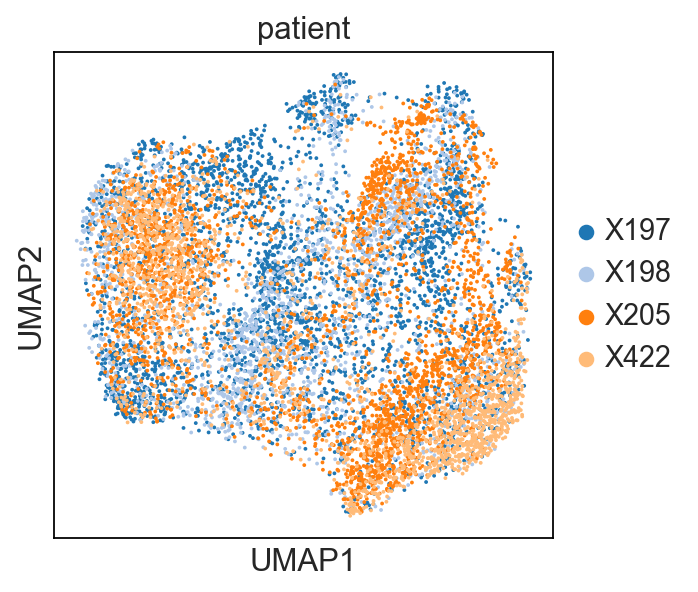

In [26]:
sc.pl.umap(adata, color='patient',
           palette=sns.color_palette("tab20", 4))

### 2B

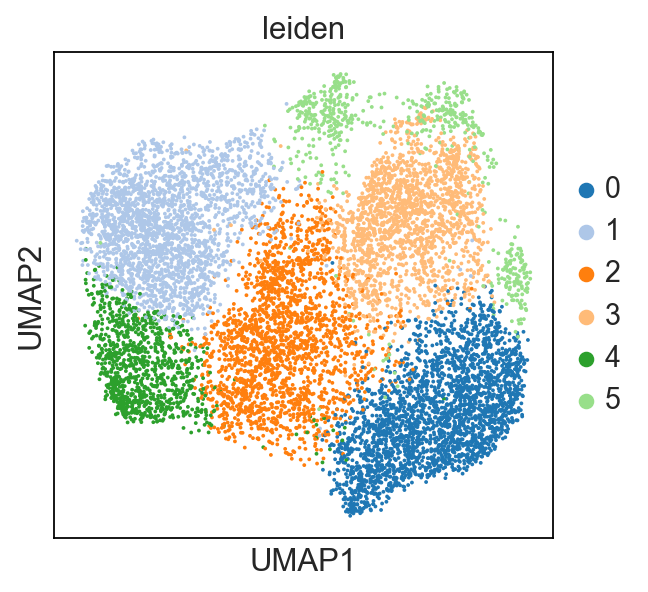

In [27]:
sc.pl.umap(adata, color='leiden',
           palette=sns.color_palette("tab20", 8))

### 2C

In [28]:
genes = ['CXCL13','FOXP3','IL7R','TCF7','GZMA','TYMS','IFNG','LAG3']

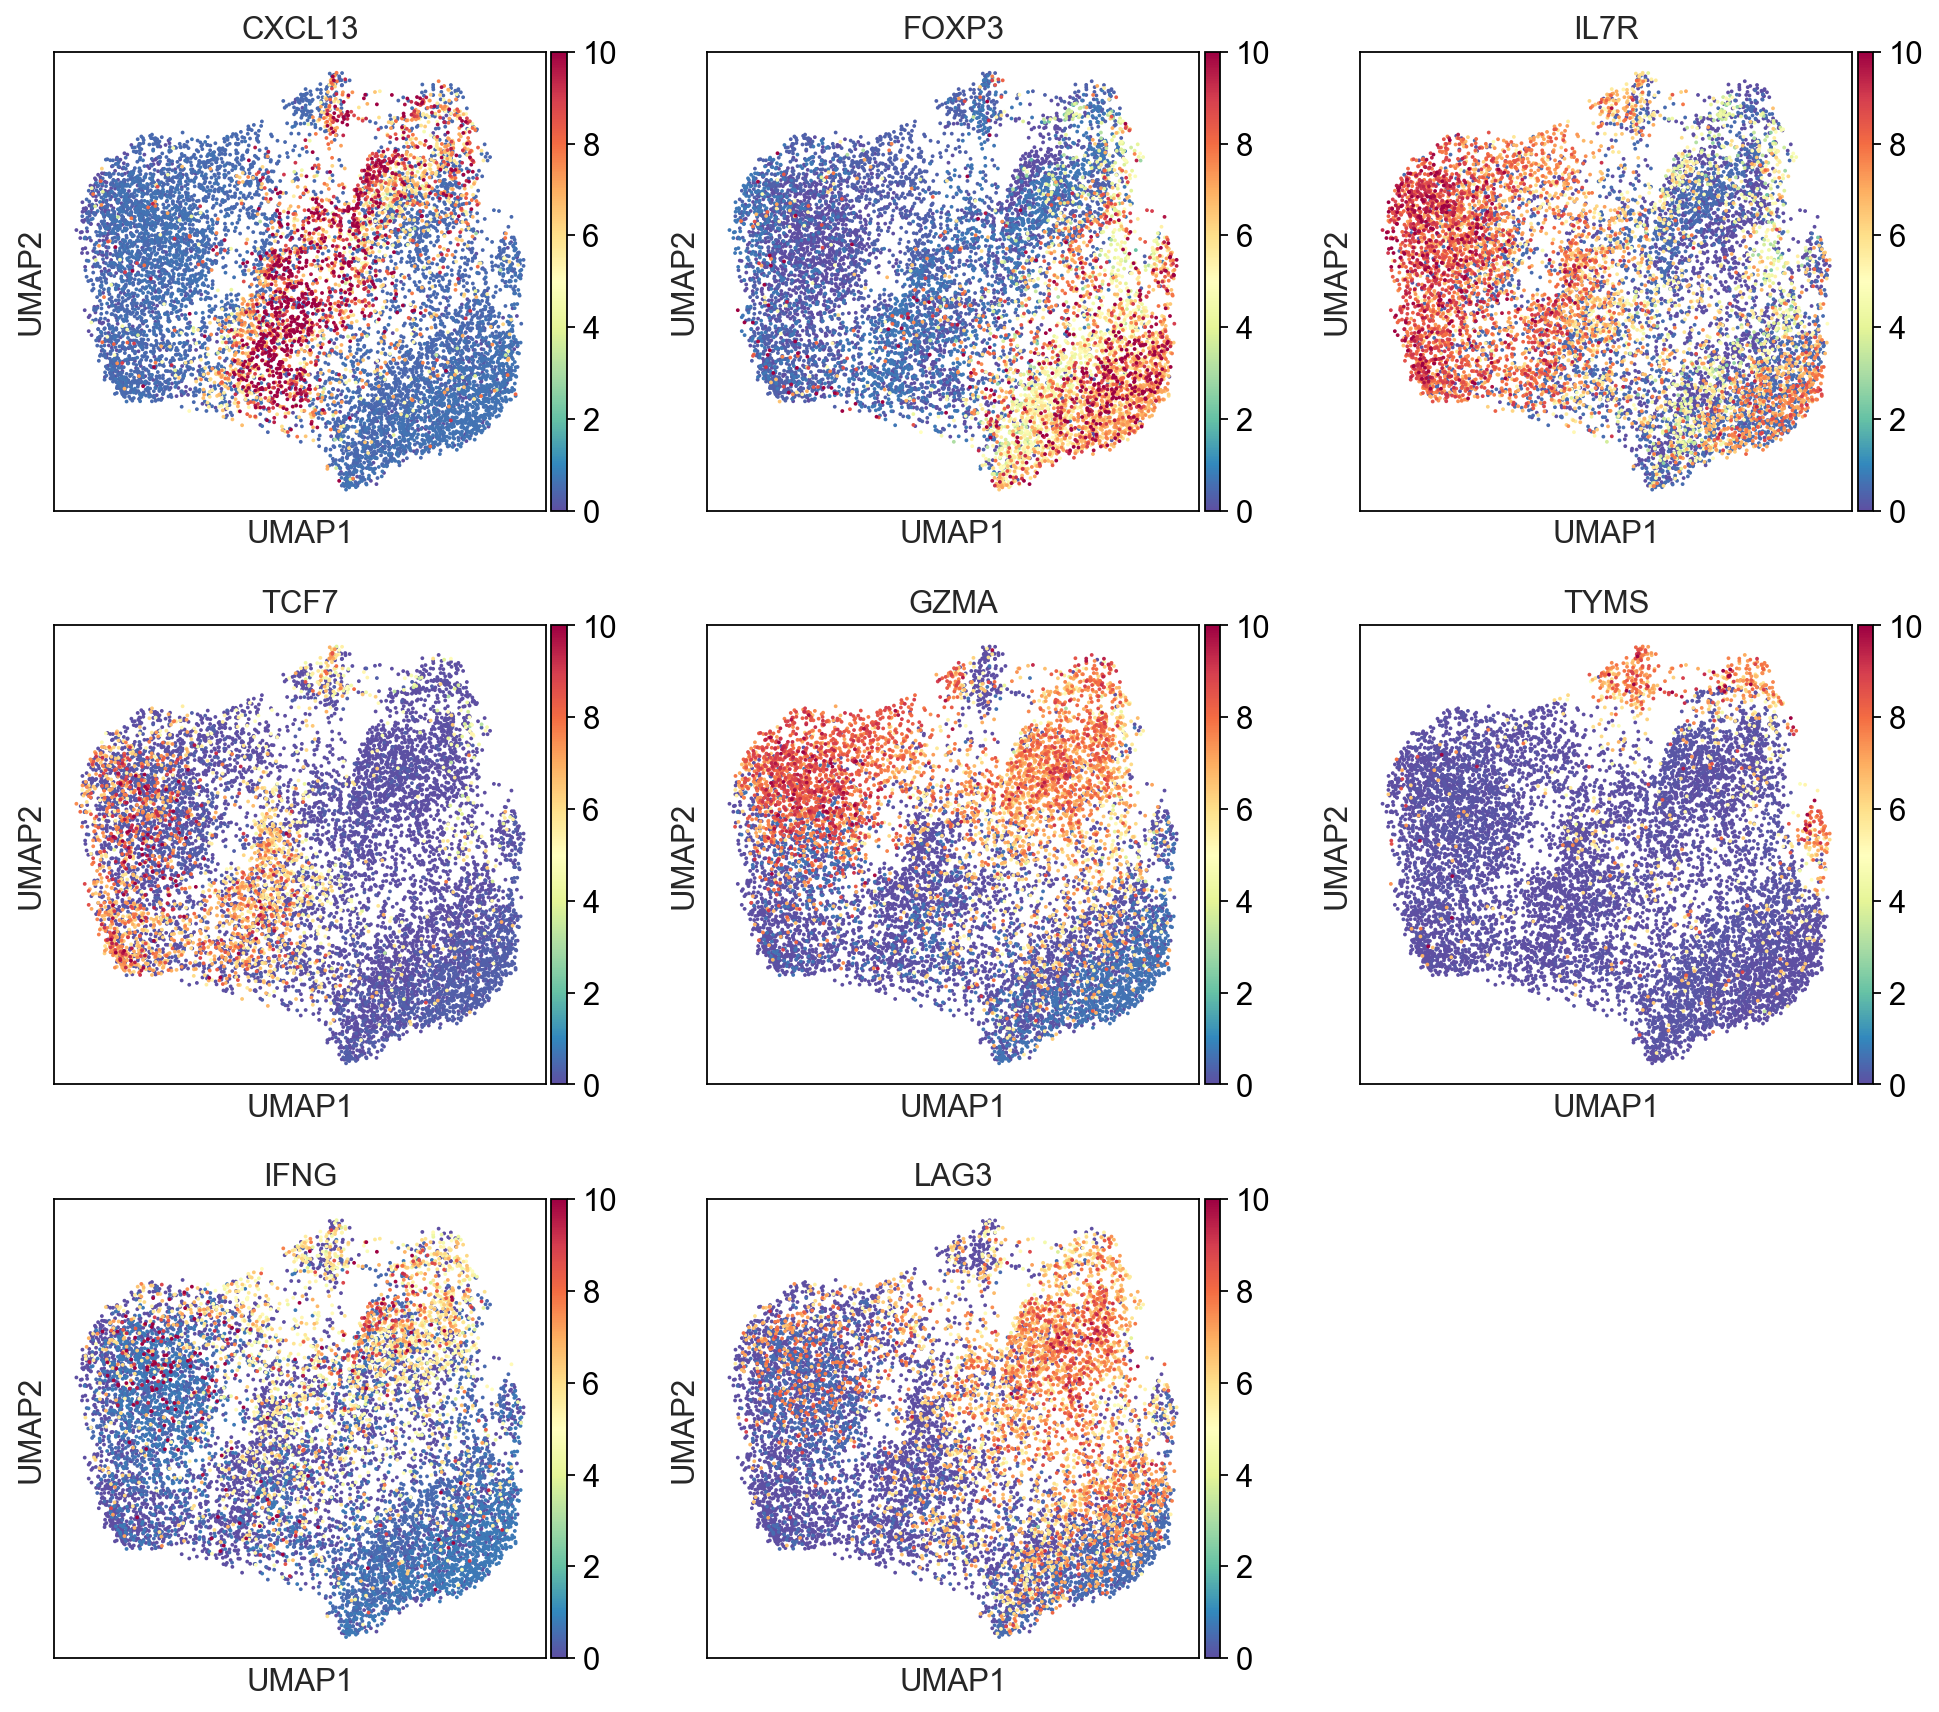

In [29]:
sc.pl.umap(adata, color=genes,vmax=10,vmin=0,
           alpha = 1,use_raw=False,ncols=3,cmap='Spectral_r')

In [30]:
ab = ['CD279 (ab)', 'CD39 (ab)']

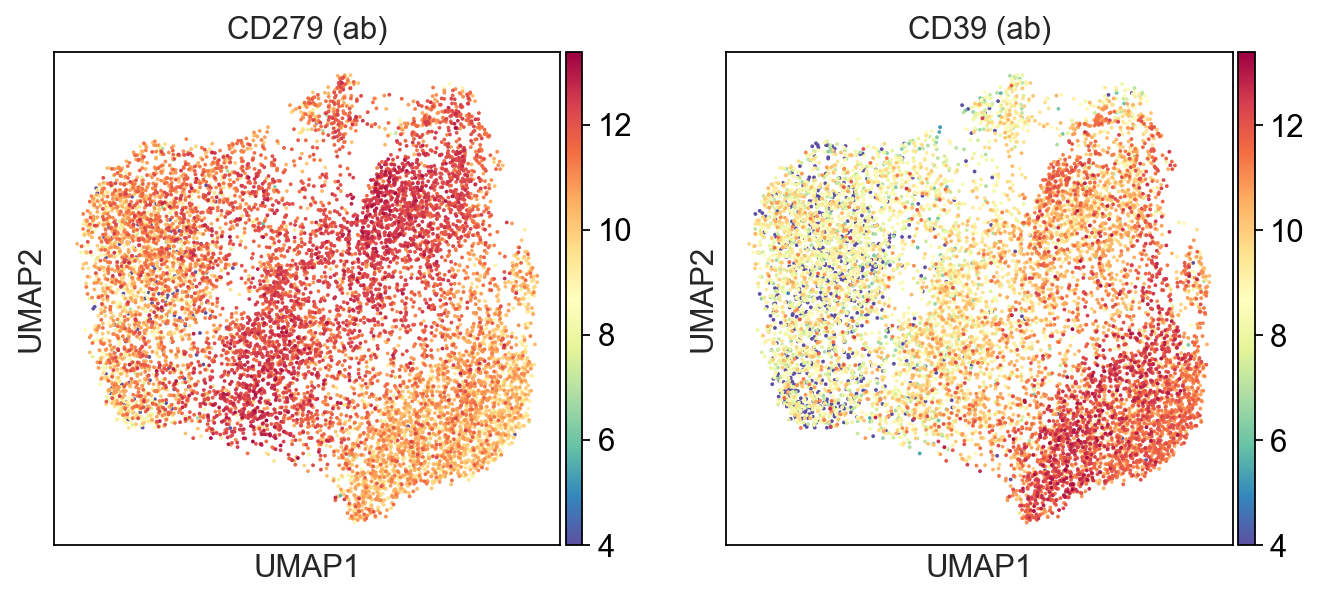

In [31]:
sc.pl.umap(adata, color=ab,vmin=4,
           alpha = 1,use_raw=False,ncols=3,cmap='Spectral_r')

In [32]:
ab = ['CXCR5 (ab)','Tim3 (ab)', 'CD103 (ab)']

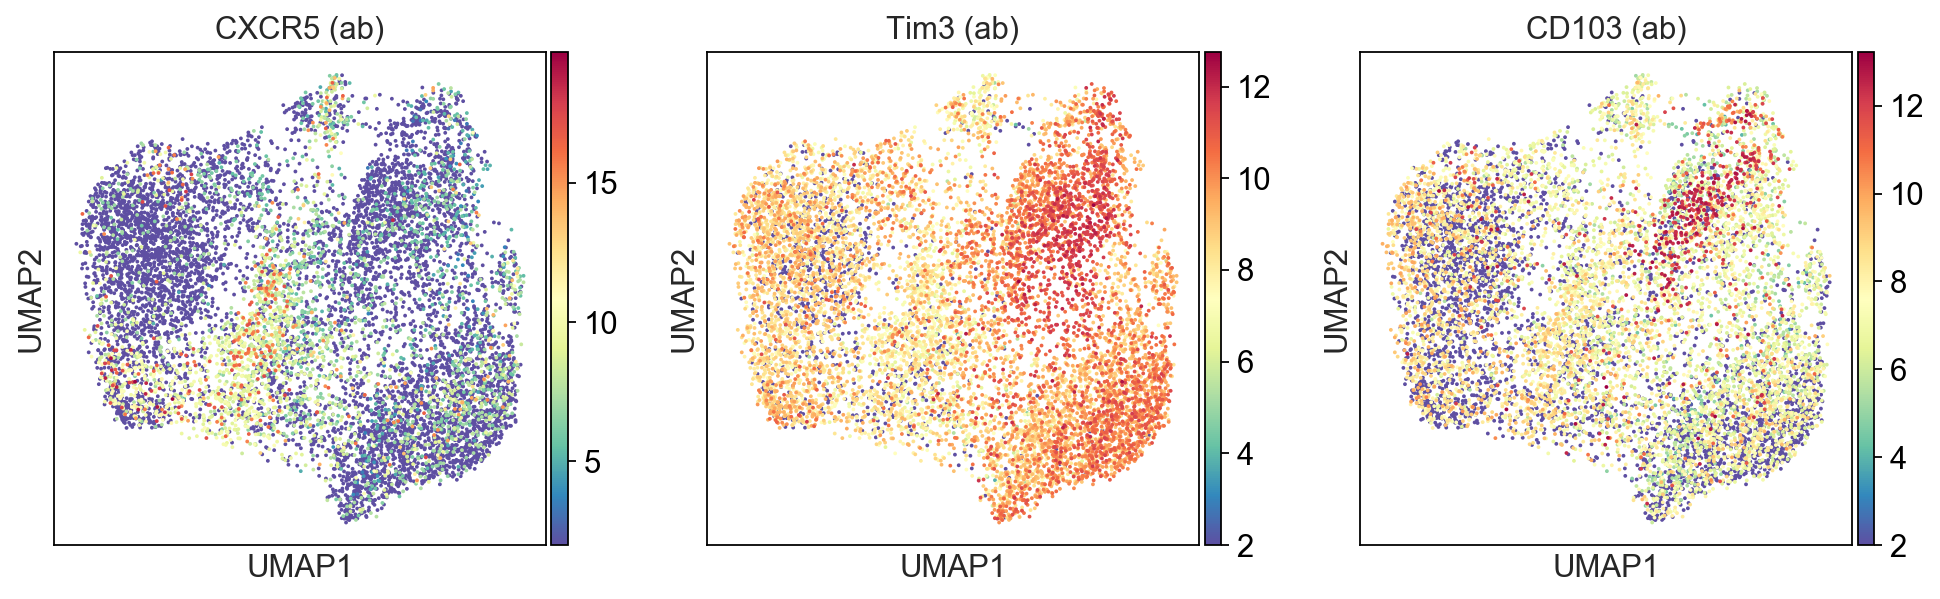

In [33]:
sc.pl.umap(adata, color=ab,vmin=2,
           alpha = 1,use_raw=False,ncols=3,cmap='Spectral_r')

### 2E

In [34]:
cmap = sns.color_palette("Set1", 2) + ['gold'] + ['red']

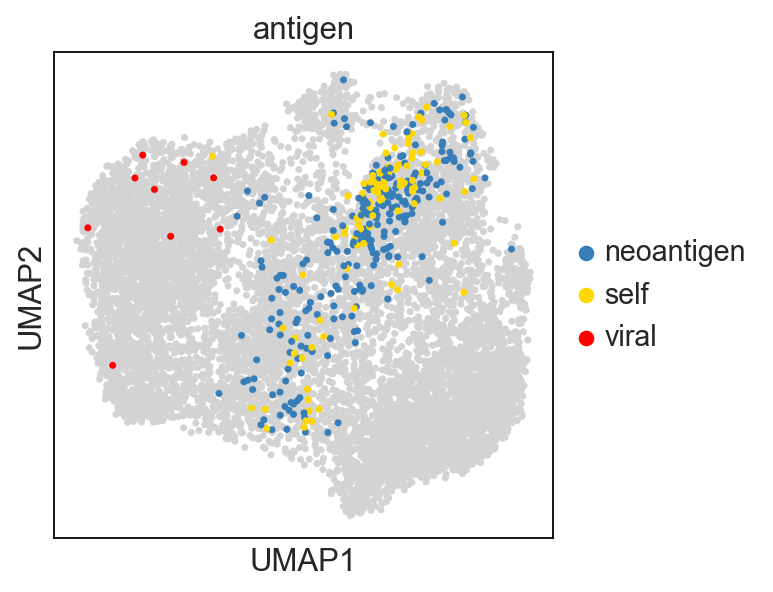

In [35]:
sc.pl.umap(adata, color='antigen',
           palette=cmap,groups=['neoantigen','self','viral'],
           alpha = 1, s=40)

### 2G

In [36]:
adata.obs['nucleotide_clone'] = 'nan'
adata.obs['nucleotide_clone'][adata.obs['antigen'] != 'nan'] = adata.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant']

In [37]:
adata.obs['expansion'] = 'nan'
for x in range(len(adata.obs['nucleotide_clone'])):
    if adata.obs['nucleotide_clone'][x] != 'nan':
        adata.obs['expansion'][x] = pd.DataFrame(adata.obs['nucleotide_clone'].value_counts()).loc[adata.obs['nucleotide_clone'][x]]['nucleotide_clone']
    else: adata.obs['expansion'][x] = 0

In [38]:
adata.obs['expansion'] = adata.obs['expansion'].astype('int')

In [39]:
pal = ['lightgrey'] + sns.color_palette("rocket_r", 5)

In [40]:
adata.obs['expansion_all'] = 'nan'
for x in range(len(adata.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant'])):
    if adata.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant'][x] != 'nan':
        adata.obs['expansion_all'][x] = pd.DataFrame(adata.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant'].value_counts()).loc[adata.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant'][x]]['TCR_Beta_Delta_CDR3_Nucleotide_Dominant']
    else: adata.obs['expansion_all'][x] = 0

In [41]:
adata.obs['expansion_cut'] = adata.obs['expansion_all'].astype('str')
adata.obs['expansion_cut'][adata.obs['expansion_all'] > 4] = '>=5'
adata.obs['expansion_cut'] = adata.obs['expansion_cut'].astype('category')

In [42]:
adata_sub = adata.copy()

In [43]:
adata_sub.obs['expansion_cut'][(adata_sub.obs['TCR_Beta_Delta_CDR3_Nucleotide_Dominant'].str.startswith('GCCAGCA')) & (adata_sub.obs['patient'] == 'X197')] = '0'

... storing 'nucleotide_clone' as categorical
... storing 'expansion_all' as categorical


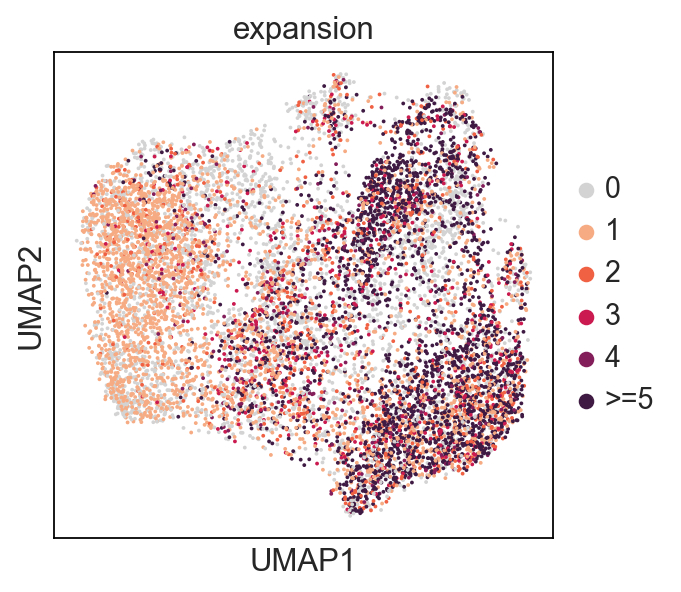

In [44]:
sc.pl.umap(adata_sub, color='expansion_cut',title='expansion',palette=pal)

### 2H

In [45]:
adata.obs['enrich'] = adata.obs['enrich'].astype('object')
adata.obs['enrich'][adata.obs['enrich'] == 'nan'] = '0.0'
adata.obs['enrich'] = pd.to_numeric(adata.obs['enrich'], errors='coerce')

In [46]:
adata.obs['enrich_log'] = np.log(adata.obs['enrich']+1)

In [47]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

... storing 'nucleotide_clone' as categorical
... storing 'expansion_all' as categorical


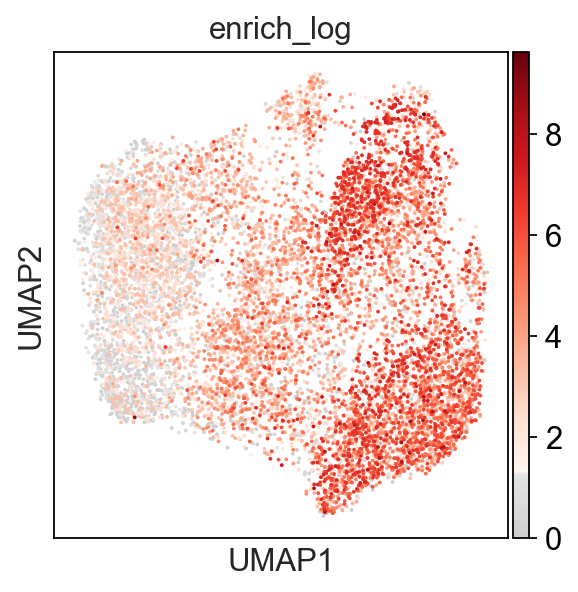

In [48]:
sc.pl.umap(adata, color='enrich_log',cmap=mymap,vmin=0)

### 2I

In [49]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


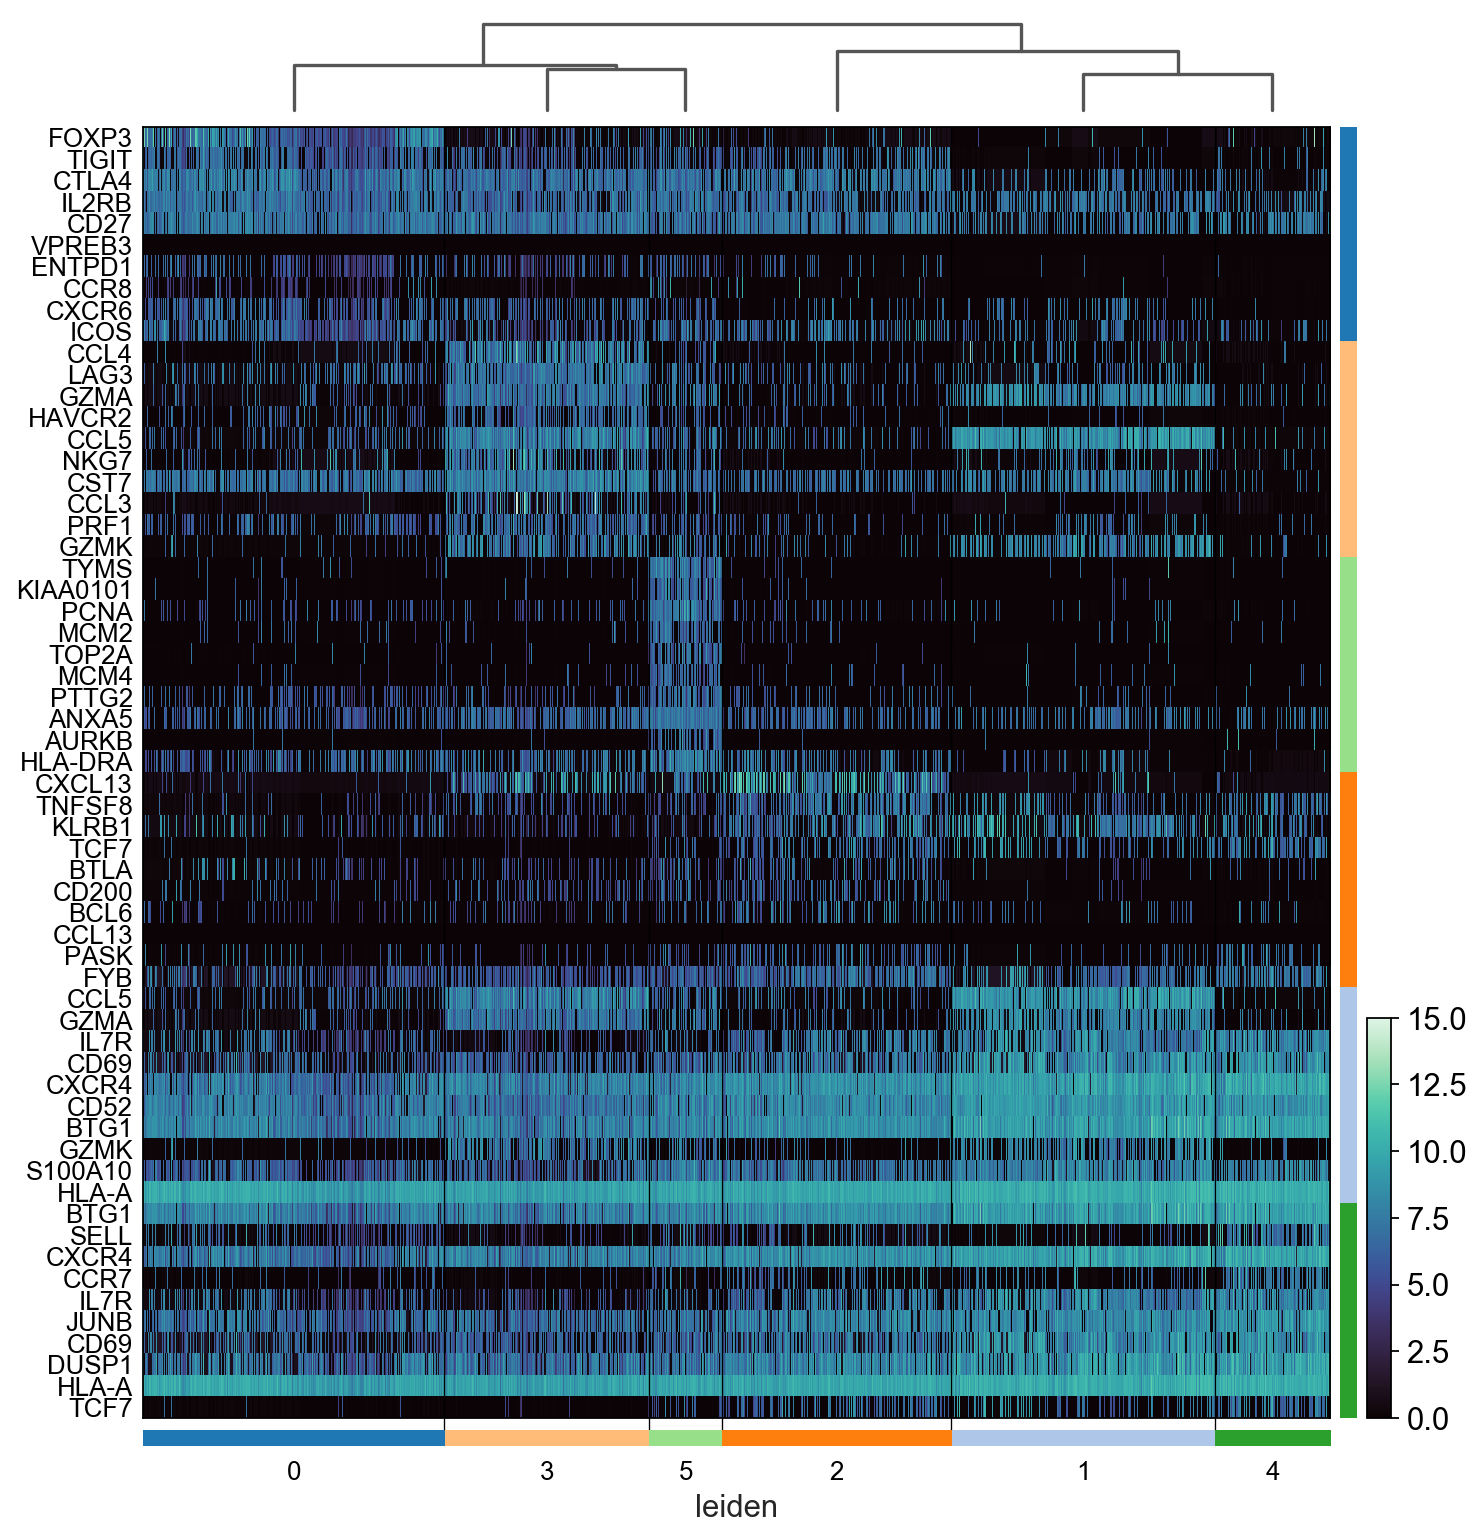

In [50]:
sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', n_genes=10,cmap='mako',
                                swap_axes=True,show_gene_labels=True,vmin=0,vmax=15)